### Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import combinations
import random
from collections import Counter
import matplotlib.ticker as ticker
import scipy

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("../../ucl_irdm2017_project2_group1"))

In [5]:
import ltr.data_load

### Data Loading and Preparation

**Run first cell once to generate CSVs. Once generated, files can be loaded in using second cell**

In [9]:
fpath = "../../"

In [ ]:
data_train = ltr.data_load.make_rank_data_csv(fpath, 1, 'train')
data_vali = ltr.data_load.make_rank_data_csv(fpath, 1, 'vali')
data_test = ltr.data_load.make_rank_data_csv(fpath, 1, 'test')

In [11]:
data_train = pd.read_csv('{fpath}train_fld1_df.csv'.format(fpath=fpath), index_col=0)
data_vali = pd.read_csv('{fpath}test_fld1_df.csv'.format(fpath=fpath), index_col=0)
data_test = pd.read_csv('{fpath}vali_fld1_df.csv'.format(fpath=fpath), index_col=0)

In [12]:
X_train = data_train.ix[:,2:].as_matrix()
y_train = data_train.ix[:,0].as_matrix()
qid_train = data_train.ix[:,1].as_matrix()
X_vali = data_vali.ix[:,2:].as_matrix()
y_vali = data_vali.ix[:,0].as_matrix()
qid_vali = data_vali.ix[:,1].as_matrix()
X_test = data_test.ix[:,2:].as_matrix()
y_test = data_test.ix[:,0].as_matrix()
qid_test = data_test.ix[:,1].as_matrix()

In [13]:
data_train.head(3)

,label,query_id,covered query term number - body,covered query term number - anchor,covered query term number - title,covered query term number - url,covered query term number - whole document,covered query term ratio - body,covered query term ratio - anchor,covered query term ratio - title,...,Length of URL,Inlink number,Outlink number,PageRank,SiteRank,QualityScore,QualityScore2,Query-url click count,url click count,url dwell time
0,2,1,3,3,0,0,3,1.0,1.0,0.000000,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,2,1,3,0,3,0,3,1.0,0.0,1.000000,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,0,1,3,0,2,0,3,1.0,0.0,0.666667,...,45,3,1,124,3344,14,67,0,0,0.0


## Size of dataset

**Number of results:**

In [14]:
print("Train: " + str(len(X_train)))
print("Validation: " + str(len(X_vali)))
print("Test: " + str(len(X_test)))
print("TOTAL: " + str(len(X_train)+len(X_vali)+len(X_test)))

Train: 723412
Validation: 241521
Test: 235259
TOTAL: 1200192


**Number of queries:**

In [15]:
print("Train: " + str(len(np.unique(qid_train))))
print("Validation: " + str(len(np.unique(qid_vali))))
print("Test: " + str(len(np.unique(qid_test))))
print("TOTAL: " + str(len(np.unique(qid_train))+len(np.unique(qid_vali))+len(np.unique(qid_test))))

Train: 6000
Validation: 2000
Test: 2000
TOTAL: 10000


**Dimensionality of data:**

In [16]:
print("Number of Dimension in input data: " + str(data_train.ix[:,2:].shape[1]))

Number of Dimension in input data: 136


## Summary statistics

In [39]:
data_train['label'].describe()

count    723412.000000
mean          0.665307
std           0.822127
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           4.000000
Name: label, dtype: float64

## Distribution of true relevance labels (comined training and validation set)

In [18]:
full_train = pd.concat([data_train, data_vali])
full_train = full_train.ix[:,['label','query_id']]

Counts of true relevance labels:

In [21]:
print(full_train['label'].value_counts())

0    502741
1    310465
2    127541
3     17108
4      7078
Name: label, dtype: int64


Percentage of true relevance labels in dataset:

In [22]:
print(full_train['label'].value_counts(normalize=True))

0    0.521011
1    0.321748
2    0.132176
3    0.017730
4    0.007335
Name: label, dtype: float64


Countplot of true relevance labels:

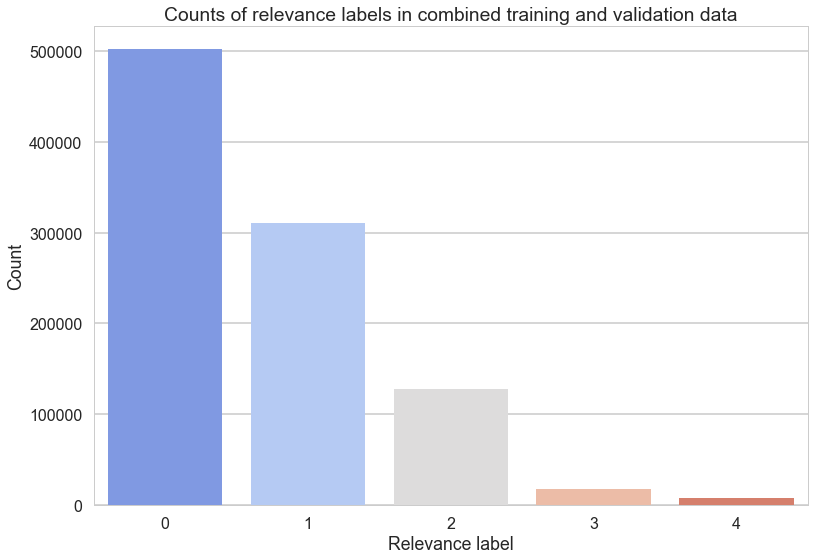

In [36]:
sns.set_style("whitegrid")
sns.set_context("poster")
ax = sns.countplot(x='label', data=full_train, palette="coolwarm")
ax.set(xlabel='Relevance label', ylabel='Count', title='Counts of relevance labels in combined training and validation data')

Boxplot of distribution of counts for each relevance label:

In [24]:
full_train_grpd = full_train.groupby('query_id')

In [25]:
label_counts = {qid:Counter(full_train_grpd.get_group(qid)['label']) for qid in list(set(full_train['query_id']))}

In [26]:
label_counts_0 = [qid[0] for qid in label_counts.values()]
label_counts_1 = [qid[1] for qid in label_counts.values()]
label_counts_2 = [qid[2] for qid in label_counts.values()]
label_counts_3 = [qid[3] for qid in label_counts.values()]
label_counts_4 = [qid[4] for qid in label_counts.values()]

In [27]:
scipy.stats.describe(label_counts_1)

DescribeResult(nobs=8000, minmax=(0, 450), mean=38.808124999999997, variance=1071.346477294037, skewness=2.0091717332440884, kurtosis=9.51075420024756)

In [28]:
label_counts_df = pd.DataFrame({'label_0':label_counts_0, 'label_1':label_counts_1, 'label_2':label_counts_2, 'label_3':label_counts_3, 'label_4':label_counts_4})

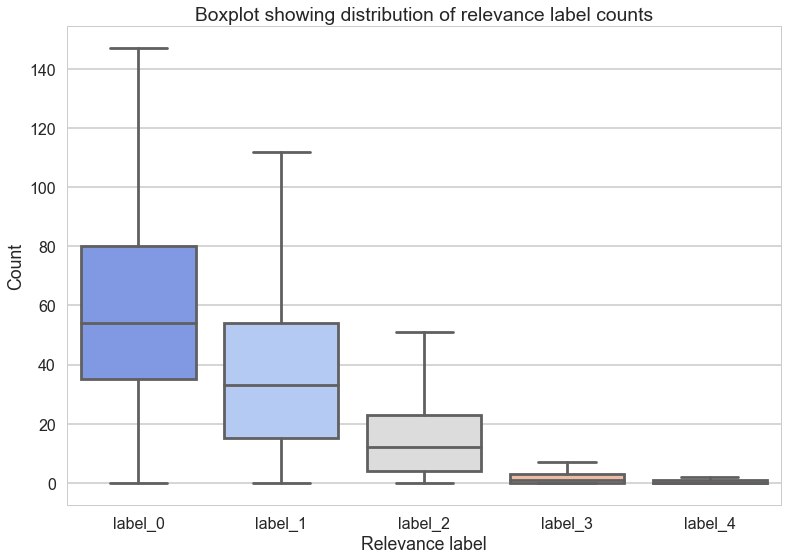

In [37]:
sns.set_style("whitegrid")
sns.set_context("poster")
ax = sns.boxplot(data=label_counts_df, palette="coolwarm", showfliers=False)
ax.set(xlabel='Relevance label', ylabel='Count', title='Boxplot showing distribution of relevance label counts')

## Number of documents per query

In [30]:
unique_qry  = full_train['query_id'].unique()
num_docs = []
for i in unique_qry:
    num_docs.append(full_train[full_train['query_id'] == i].shape[0])

In [31]:
data = pd.DataFrame({'Query':unique_qry,'Number of Documents':num_docs})
data.sort_values(by="Number of Documents",ascending=False,inplace=True)
data.index = range(len(unique_qry))

In [32]:
query_id_order = list(data['Query'])

 [],

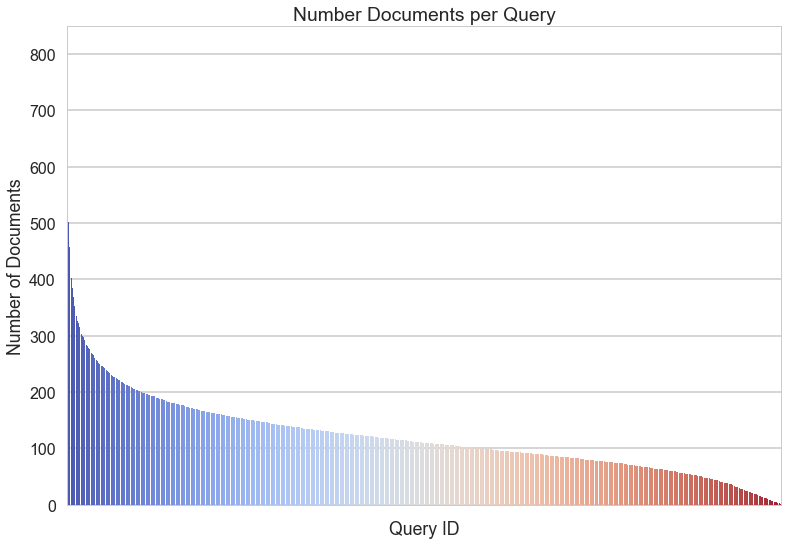

In [38]:
ax = sns.countplot(x="query_id", data=full_train, order=query_id_order, palette="coolwarm")
sns.set_style("white")
ax.set(xlabel='Query ID', ylabel='Number of Documents',title="Number Documents per Query", xticklabels=[])